[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2023/blob/feature/class_01/docs/class_01.ipynb)

# CNNを利用したCIFAR-10データセットでの学習

次の流れで畳み込みニューラルネットワーク(CNN)を使用した10クラス分類の教師あり学習の実装を以下の順番で行なっていきます。
- データセットの作成(今回はCIFAR-10というデータセットを使用します)
- モデルの作成
- 損失関数、最適化関数の定義
- モデルの学習
- モデルの評価

まず、本日の演習で使用するライブラリをインポートします。\
今回の演習では`pytorch`と呼ばれるライブラリを使用してニューララルネットワークの実装を行います。

In [1]:
## Pytorch関連ライブラリ
import torch
import torchvision
import torchvision.transforms as transforms

## CIFAR-10データローダーの作成

### CIFAR-10とは

- 合計で6万枚のRGB画像(32x32)を含むデータセット
- クラス数は10クラス(各クラス学習用5000枚、評価用1000枚)

### データセットの作成

pytorchでは、torchvisionのライブラリを使用することで`torchvision.datasets.CIFAR10`のように事前に決められた[データセット](https://pytorch.org/vision/0.8/datasets.html)を使用することができます。\

`root`はデータセットを保存するパスを指定します。
今回は`path`という変数を使用しているため、`path`を書き換えることでデータの保存先を各自変更してください。
例えば、Google Driveの配下の`b3_proj_2023/data`に学習用データを保存する場合は`path`を
```python
path = "./drive/My Drive/Colab Notebooks/b3_proj_2023/data"
```
のように変更します。
(このように自身のGoogle Drive上に保存することで次回以降にデータを再度ダウンロードする必要がなくなるので便利です。)

`train=True|False`で学習データか評価データかを指定することができます。 \
また、`transform`でデータ変換やデータオーグメンテーションを指定することができます。
データ変換は複数同時に適用することがほとんどで、そのような場合は`transforms.Compose`を使用して複数のデータ変換を一連の処理として指定します。
```python
transform = transforms.Compose(
    [transforms.ToTensor(),
    ...
     ])
```
のようにpythonのリストで指定し、データを読み込む際に上から順番に実行されます。
適用可能な関数の一覧は[こちら](https://pytorch.org/vision/main/transforms.html)を参照してください。

## データローダーの作成

データセットに含まれるデータ数は非常に大きく、一度にメモリに読み込むことは難しい場合が多いです。\
そのため、そこで一度に読み出すデータの数を減らすことで計算負荷を減らしています。\
これをミニバッチと呼び、ロードするデータ数をバッチサイズと呼びます。

pytorchでは、こうしたバッチ処理を`DataLoader`というクラスを用いて行います。\
`DataLoader`は`batch_size`という引数で一度に読み出すデータの数を指定することができます。

In [18]:
## Please update the path to your own directory.
# path=/path/to/your_own  # Uncomment this line
path = '../../work/data/cifar10'

## Define Augmentation
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root=path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### データセット・データローダーの確認

先ほどのデータセットにどのようなデータが保存されているのか確認します。

`images`は$[\rm{batch\_size}\times 3\times 32\times 32]$のテンソルでモデルの入力に使用します。\
また、`labels`は$[\rm{batch\_size}]$のテンソルで学習のラベルとして使われます。

下のセルを実行すると変数`batch_size`で指定した数と同じ枚数の画像が出力されるのがわかるかと思います。

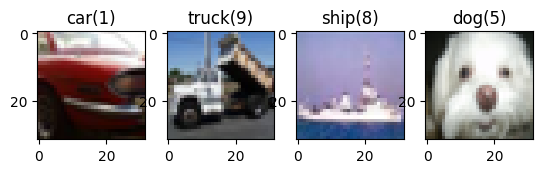

car   truck ship  dog  


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
torch.manual_seed(15)

def imshow(imgs, labels):
    imgs = imgs / 2 + 0.5     # unnormalize
    npimg = imgs.numpy()
    for i, (img, label) in enumerate(zip(npimg, labels)):
        plt.subplot(1, batch_size, i+1)
        plt.grid(False)
        plt.imshow(np.transpose(img, (1, 2, 0)))
        label = label.item()
        plt.title(f"{classes[label]}({label})")

    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(images, labels)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 演習

**演習1**: データ変換に正規化を追加してください。\
**演習2**: バッチサイズを4に変更した場合に出力がどう変化するか確認してください。\
**(演習3)**: ランダムに上下を反転させるデータ変換を追加してください。

## モデルの作成
ここでは、推論に使用するモデルの作成を行います。

モデルを作成する前にニューラルネットワークで広く用いられるモデルの構成要素について簡単に説明します。

### 全結合層
<img src="../resources/class_01/fully_connected.png" width="10%">

全結合層とは、入力と出力が全て重みによって結合されている層を指します。\
図では、一次元で表していますが、`pytorch`ではバッチ処理が行われるため実際は2次元の入力に対して処理が行われます。\
そのため、入力$\mathbf{x} \in \mathbb{R}^{B\times C_{\rm in}}$に対して、重み$W\in\mathbb{R}^{C_{\rm in}\times C_{\rm out}}$とバイアス$\mathbf{B} \in \mathbb{R}^{B\times C_{\rm out}}$を用いて出力$y\in\mathbb{R}^{B\times C_{\rm out}}$は次のように計算されます。
$$\mathbf{y} = \mathbf{x}\mathbf{W} + \mathbf{B}$$
ここで、$B$はバッチサイズ、$C_{\rm in}$、$C_{\rm out}$は入力チャネル、出力チャネル数を表しています。

`pytorch`では`nn.Linear`というクラスで実装されています。\
`in_features`で入力のチャネル数、`out_features`で出力のチャネル数を指定します。

例えば、入力チャネルが$4$、出力チャネルが$10$の全結合層は次のように実装します。

In [60]:
import torch.nn as nn
input = torch.rand((4, 3))
print(f'Input Shape is {input.shape}')
linear = nn.Linear(in_features=3, out_features=10)
output = linear(input)
print(f'Output Shape is {output.shape}')

Input Shape is torch.Size([4, 3])
Output Shape is torch.Size([4, 10])


演習
上のセルを修正して入力チャネルが5、出力チャネルが15の線形層を`nn.Linear`を用いて実装してください。\
このとき、入力のバッチサイズを4とし、線形層の入力チャネルと入力データのチャネル数を揃える必要があることに注意してください。


### 畳み込み層
<img src="../resources/class_01/conv1d.png" width="30%">

全結合層では全ての入力チャネルと出力チャネルが重みで結合されていたのに対し、畳み込み層では入力に対してカーネルをストライドさせることで出力を計算します。\
そのため、出力のサイズは、カーネルサイズ、ストライド、パディングによって決定されます。\
画像では1次元のデータに対する1次元の畳み込みを例にしていますが、画像のデータセットでは4次元の入力に対し2次元の畳み込みを行うことが一般的です。\
この場合カーネルは$[C_{\rm out}, C_{\rm in}, k_{\rm h}, k_{\rm w}]$の4次元のテンソルで定義され、このカーネルを画像の縦横方向にストライドさせることで計算を行う。

例えば、入力サイズが$[4, 3, 10, 10]$のデータに対して、出力チャネル6、カーネルサイズ3、パディングおよびストライドが1の畳み込みは次のように実装されます。

In [64]:
import torch.nn as nn
input = torch.rand((4, 3, 10, 10))
print(f'Input Shape is {input.shape}')
conv2d = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1, stride=1)
output = conv2d(input)
print(f'Output Shape is {output.shape}')

Input Shape is torch.Size([4, 3, 10, 10])
Output Shape is torch.Size([4, 6, 10, 10])


演習
上のセルを修正して入力チャネルが5、出力チャネルが10のカーネルサイズが5、パディングが0、ストライドが1のConvを実装してください。\
このとき、入力のバッチサイズを4とし、入力チャネルと入力データのチャネル数を揃える必要があることに注意してください。\
出力のサイズが変化していることを確認してください。

### プーリング層

- 畳み込み層と異なり、チャネル間のやり取りはない
- フィルタで行われる処理が決まっている。
    - maxpool2dはフィルタ内の最大値
    - avgpool2dはフィルタ内の平均

### 活性化関数

ここまでで説明した4つの構成要素を用いてニューラルネットワークは次のように実装されます。\
ここでは、畳み込み1層、プーリング層1層、全結合層1層のニューラルネットワークを実装しています。

In [65]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=6*14*14, out_features=10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

### 実際にモデルを動かしてみよう

ここでは乱数を入力としてモデルを動かしてみます。
ニューラルネットワークは、入力サイズ$(B, C, H, W)$のテンソルを入力として、$(B, \rm{Cls})$を出力とします。\
ここで$B$はバッチサイズ、$C$は入力チャネル数(RGB画像の場合は3チャネル)、$H$, $W$は画像の幅と高さになります。CIFAR-10データセットの場合は、$H=W=32$です。\
$\rm{Cls}$は出力のクラス数を表し、CIFAR-10は10クラスを出力します。\
ここでは、$(B, C, H, W) = (1, 3, 32, 32)$の乱数を入力としてモデルの推論を行います。\
実際にコードを実行すると(1, 10)の出力が得られると思います。配列の各要素がそれぞれのクラスの予測値となります。

In [56]:
torch.manual_seed(100)

input = torch.rand((1, 3, 32, 32))
net = Net()
output = net(input)

print(output)

pred = torch.load('../resources/model_out.pt')
assert torch.isclose(pred, output).all(), "Your model is something wrong"

tensor([[ 0.0866, -0.0884,  0.0710, -0.0071,  0.1062, -0.0669,  0.0191,  0.1204,
         -0.0822,  0.0801]], grad_fn=<AddmmBackward0>)


演習\
`Net`クラスを修正して以下で定義されるモデルを実装してください。\
Conv2dは全て`padding=0`、`stride=1`で、MaxPool2dは`stride=2`で実装してください。\
それぞれの層のカーネルサイズは、テーブルの`Kernel Shape`を元に決定してください。\
それぞれの層のチャネル数は、入力チャネル、出力チャネルを参考に実装してください。\
最終層以外のConv, Linear層の後には

```
===================================================================================================================
Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape
===================================================================================================================
Net                                      [4, 3, 32, 32]            [4, 10]                   --
├─Conv2d: 1-1                            [4, 3, 32, 32]            [4, 6, 28, 28]            [5, 5]
│    └─weight                                                                                [3, 6, 5, 5]
│    └─bias                                                                                  [6]
|-ReLU                                   [4, 6, 28, 28]            [4, 6, 28, 28]
├─MaxPool2d: 1-2                         [4, 6, 28, 28]            [4, 6, 14, 14]            2
├─Conv2d: 1-3                            [4, 6, 14, 14]            [4, 16, 10, 10]           [5, 5]
│    └─weight                                                                                [6, 16, 5, 5]
│    └─bias                                                                                  [16]
|-ReLU                                   [4, 16, 10, 10]           [4, 16, 10, 10]
├─MaxPool2d: 1-4                         [4, 16, 10, 10]           [4, 16, 5, 5]             2
├─Linear: 1-5                            [4, 400]                  [4, 120]                  --
│    └─weight                                                                                [400, 120]
│    └─bias                                                                                  [120]
|-ReLU                                   [4, 120]                  [4, 120]
├─Linear: 1-6                            [4, 120]                  [4, 84]                   --
│    └─weight                                                                                [120, 84]
│    └─bias                                                                                  [84]
|-ReLU                                   [4, 84]                   [4, 84]
├─Linear: 1-7                            [4, 84]                   [4, 10]                   --
│    └─weight                                                                                [84, 10]
│    └─bias                                                                                  [10]
===================================================================================================================
```



## 損失関数とオプティマイザの定義

損失関数$L$とはモデルの予測値と正解ラベルの誤差を計算するための関数です。\
損失関数は`CrossEntropyLoss`というラベルデータの確率分布と出力の確率分布の誤差を計算する関数が主に使用されます。\
また、オプティマイザーとはパラメータを更新するための関数で、画像認識では`SGD`や`Adam`などが広く使用されています。

pytorchでは次のように関数として実装されているものを使用します。

`SGD`の第一引数は更新するパラメータを指定しています。\
第二引数は学習率と呼ばれ、一度に更新するパラメータの大きさを調整しています。\
`momentum`や、今回は使われていませんが`weight_decay`といった引数はニューラルネットワークの学習を安定させたり過学習を抑制するために使用します。

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### ニューラルネットワークの学習

では、先ほど定義した損失関数とoptimizerを使用して実際にニューラルネットワークの学習を行いましょう。\
最初に説明した通り、ニューラルネットワークの学習はミニバッチ学習と呼ばれるデータセットの一部のデータを使用してパラメータを更新する作業を繰り返し行います。\
データセット内の全てのデータが学習に使用されるイテレーションの数を1エポックと呼び、複数エポック学習することでパラメータの最適化を行います。\

各イテレーションでは、次の4つの処理を主に行います。
- モデルの推論(順伝播)
    - ミニバッチ入力に対してモデルが予測値を出力します。
- 損失の計算
    - モデルの予測値と正解ラベルの誤差を計算します。
- 勾配のリセット
    - 前のイテレーションでパラメータの更新に使用した勾配のリセット。
- 勾配の計算(逆伝播)
    - 損失を元に各パラメータの勾配計算を行います。
- パラメータの更新

In [21]:
for epoch in range(2):
    running_loss = 0.
    for i, data in enumerate(trainloader, 0):
        inputs, lables = data

        # 1. forward
        outputs = net(inputs)
        # 2. compute loss
        loss = criterion(outputs, labels)
        
        # 3. reset parameter gradient
        optimizer.zero_grad()

        # 4. backward
        loss.backward()

        # 5. update parameters
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.395
[1,  4000] loss: 1.394
[1,  6000] loss: 1.390
[1,  8000] loss: 1.391
[1, 10000] loss: 1.391
[1, 12000] loss: 1.391
[2,  2000] loss: 1.390
[2,  4000] loss: 1.390
[2,  6000] loss: 1.391
[2,  8000] loss: 1.390
[2, 10000] loss: 1.391
[2, 12000] loss: 1.389
Finished Training


### テストデータを使用した検証
では、先ほど学習したモデルを使用して新しい検証用データに対する精度を測ってみましょう。

まずは、評価に使うデータをテストデータセットからロードします。

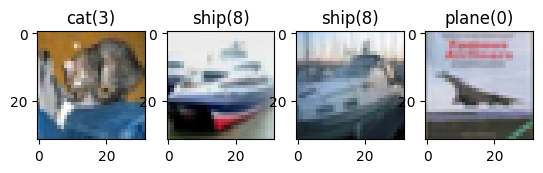

GroundTruth:  cat   ship  ship  plane


In [22]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(images, labels)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

先ほどロードしたデータを用いて推論を行います。

In [23]:
with torch.no_grad(): # Gradient計算を無効にします
    outputs = net(images)

予測結果を出力してみましょう。

In [24]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  truck ship  dog   dog  


結果はどうでしたか。
次は、テストデータセットを全て用いて精度を確認しましょう。

In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 7 %


クラスごとの精度も確認してみましょう。
どのクラスの精度が一番高かったですか。

In [27]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 12.9 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 31.7 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 16.5 %
Accuracy for class: truck is 17.8 %


学習したモデルは、次のように保存することができます。

In [28]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

保存したモデルは次のようにすることで、保存したパラメータを使用することができます。

In [29]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

最後に学習をGPUを用いて行うように変更します。\
GPUを使用して学習するためには、モデルとデータをGPUに送る必要があります。

まずは、GPUが使用可能か確認します。
次のコードで`False`という結果が出たらGoogle Colaboratoryのランタイムを`GPU`に変更してみてください。

In [30]:
print(torch.cuda.is_available())

True


GPUが使用可能であることがわかったら、モデルとデータをGPUで利用できるようにします。
まず、deviceという変数を一番初めのpythonセルに追加してください。

```python
## Pytorch関連ライブラリ
import torch
import torchvision
import torchvision.transforms as transforms

device = 'cuda:0' # 0番目のGPUをdeviceとして指定
```

モデルの定義部分と、入力及びラベルデータを次のように変更してください。

```python
net = Net()
net = net.to(device)
```

```python
# inputs, labels = data
inputs, labels = data[0].to(device), data[1].to(device)
```

## 宿題
**課題1**: VGG11を実装して評価してください。\
(**課題2**): データ拡張、モデルなどを変更してCIFAR-10の精度を向上させてください。